In [1]:
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
from scipy import optimize

In [131]:
payouts = {
    "pow": {
        2: [0, 0, 3],
        3: [0, 0, 0, 5],
        4: [0, 0, 0, 0, 10],
    },
    "flex": {
        # 2: [0, 0.5, 2],
        3: [0, 0, 1.25, 2.25],
        4: [0, 0, 0, 1.5, 5],
        5: [0, 0, 0, 0.4, 2, 10]
    }
}

def return_given_outcomes(style, k, n_legs, outcomes):
    combos = list(itertools.combinations(outcomes, k)) # Every combination of k outcomes
    n_combos = len(combos) # Number of combinations
    if len(combos) == 0:
        print(outcomes, k)
    win_counts = [sum(combo) for combo in combos] # Number of wins for each combination
    win_count_counts = Counter(win_counts) # Count of each number of wins
    
    total_payout = sum([
        win_count_counts[n_wins] * payouts[style][k][n_wins] # Payout for each number of wins
        for n_wins in win_count_counts
    ])
    return total_payout / n_combos

def rand_return(style, k, n_legs, win_rate):
    outcomes = [random.random() < win_rate for _ in range(n_legs)]
    return return_given_outcomes(style, k, n_legs, outcomes)
    
    
    

In [68]:
def get_prob(n_wins, n_legs, win_rate):
    return win_rate**n_wins * (1-win_rate)**(n_legs-n_wins) *  math.comb(n_legs, n_wins)

for n_wins in range(5, -1, -1):
    print(n_wins, round(get_prob(n_wins, 5, 0.66), 4))

5 0.1252
4 0.3226
3 0.3323
2 0.1712
1 0.0441
0 0.0045


In [101]:
def calculate_kelly(style, k, n_legs, win_rate):
    def neg_log_series(x):
        total = 0
        for n_wins in range(n_legs+1):
            p = get_prob(n_wins, n_legs, win_rate)
            
            if p == 0:
                continue

            outcomes = [True] * n_wins + [False] * (n_legs-n_wins)

            b = return_given_outcomes(style, k, n_legs, outcomes) - 1
            
            total += p * math.log(1 + b*x)
        return -total
    
    # Use scipy.optimize.minimize to find the maximum of the log series
    kelly = optimize.minimize_scalar(neg_log_series, bounds=(0, 1), method="bounded").x
    return kelly


kelly = {} # Kelly coefficient for each style and k

for style in payouts:
    kelly[style] = {}
    for k in payouts[style]:
        kelly[style][k] = calculate_kelly(style, k, 5, 0.6)


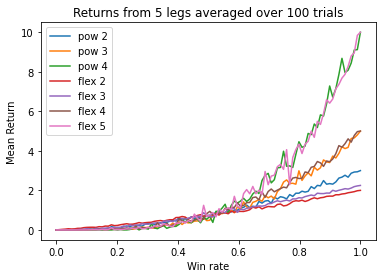

In [76]:
n_legs = 5
win_rate = 0.55


n_trials = 100
win_rates = np.linspace(0, 1, 100)

styles = ["pow", "flex"]
k_values = [2, 3, 4, 5]

for style in payouts:
    for k in payouts[style]:
        returns = [
            sum([rand_return(style, k, n_legs, win_rate) for _ in range(n_trials)]) / n_trials
            for win_rate in win_rates
        ]
        plt.plot(win_rates, returns, label=f"{style} {k}")

# Add title with n_legs
plt.title(f"Returns from {n_legs} legs averaged over {n_trials} trials")

# add axis labels
plt.xlabel("Win rate")
plt.ylabel("Mean Return")

plt.legend()
plt.show()

pow 2, win rate=0.55, 5 legs
Average Return: -69.31%
STD of Return: 38.36%
Sharpe Ratio: -1.81
Profit Prob:  4.30%


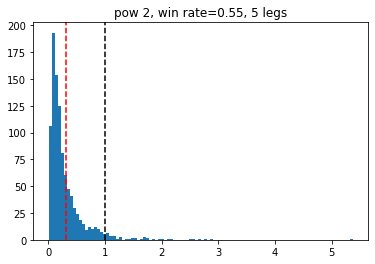

pow 3, win rate=0.55, 5 legs
Average Return: -53.70%
STD of Return: 31.42%
Sharpe Ratio: -1.71
Profit Prob:  5.00%


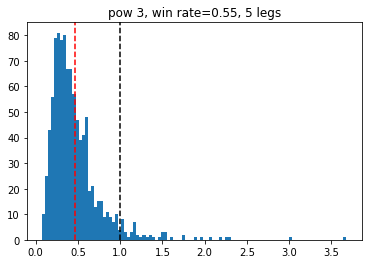

pow 4, win rate=0.55, 5 legs
Average Return: -44.09%
STD of Return: 94.71%
Sharpe Ratio: -0.47
Profit Prob:  13.80%


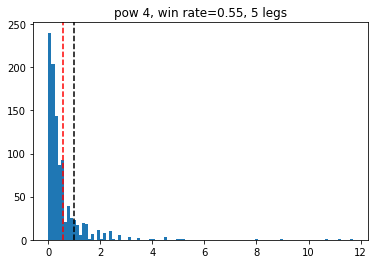

flex 3, win rate=0.55, 5 legs
Average Return: -52.61%
STD of Return: 19.10%
Sharpe Ratio: -2.75
Profit Prob:  1.80%


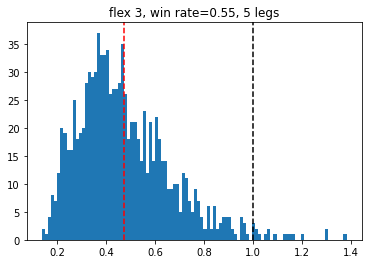

flex 4, win rate=0.55, 5 legs
Average Return: -60.57%
STD of Return: 71.73%
Sharpe Ratio: -0.84
Profit Prob:  8.30%


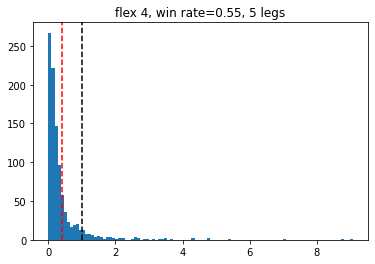

flex 5, win rate=0.55, 5 legs
Average Return: 24.52%
STD of Return: 363.10%
Sharpe Ratio: 0.07
Profit Prob:  20.10%


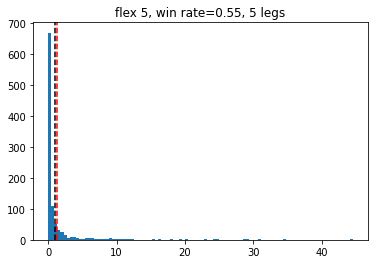

In [162]:
n_legs = 5
win_rate = 0.55
# probs = [0.8, 0.1, 0.1]
# confs = [0.55, 0.65, 0.75]



n_gamblers = 1000
n_timesteps = 100
for style in payouts:
    for k in payouts[style]:
        if k > n_legs:
            continue

        wager_percent = kelly[style][k]
        results = np.zeros((n_gamblers, n_timesteps))
        for i in range(n_gamblers):
            for j in range(n_timesteps):
                # win_rate = np.random.choice(confs, 1, p=probs)[0]
                results[i, j] = rand_return(style, k, n_legs, win_rate)
            
        results = (results - 1) * wager_percent + 1
        # log returns
        log_rets = np.log(results + 1e-10)

        # cumulative sum
        cum_sum = np.exp(np.cumsum(log_rets, axis=1)) # (n_gamblers, n_timesteps)

        # plot each gambler's cumulative sum
        # for i in range(n_gamblers):
        #     plt.plot(cum_sum[i])

        # calculate average return
        avg_return = np.mean(cum_sum, axis=0) # (n_timesteps,)
        std_return = np.std(cum_sum, axis=0) # (n_timesteps,)
        # plt.plot(avg_return)
        # plt.fill_between(range(n_timesteps), avg_return - std_return, avg_return + std_return, alpha=0.2)

        # histogram of returns
        plt.hist(cum_sum[:, -1], bins=100)


        print(f"{style} {k}, win rate={win_rate}, {n_legs} legs")
        print("Average Return: %.2f%%" % (100 * (avg_return[-1]-1)))
        print("STD of Return: %.2f%%" % (100 * std_return[-1]))
        print("Sharpe Ratio:", round((avg_return[-1]-1)/std_return[-1], 2))
        print("Profit Prob:  %.2f%%" % (100 * np.mean(cum_sum[:, -1] > 1)))

        # veritical line for average return
        plt.axvline(x=avg_return[-1], color="r", linestyle="--")
        # vertical line at return=1
        plt.axvline(x=1, color="k", linestyle="--")

        plt.title(f"{style} {k}, win rate={win_rate}, {n_legs} legs")
        # plt.xlabel("Time Step")
        # plt.ylabel("Cumulative Return")
        plt.show()